### MSCI 598 - Final Project
### Gaurav Mudbhatkal - 20747018

In [1]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler, random_split
import torch.nn.functional as F

import os

from utils.model import StanceDetectionModel

from utils.data import FNCDataset, pipeline_train, pipeline_test

from utils.config import VECTOR_SIZE, DROPOUT, BATCH_SIZE, LEARNING_RATE, WEIGHT_DECAY, EPOCHS, LABEL_MAP_REV, DATA_PATH

from utils.util import save_predictions, get_weights

#### Data Processing

In [2]:
# 1、load data
train_all_dataset = FNCDataset(mode='train')
test_dataset = FNCDataset(mode='test')

In [3]:
# 2. vectorizing the test set
bow_vectorizer, tfreq_vectorizer, tfidf_vectorizer = \
    pipeline_train(train_all_dataset, test_dataset, vector_size=VECTOR_SIZE)
pipeline_test(test_dataset, bow_vectorizer, tfreq_vectorizer, tfidf_vectorizer)

# set train and validation split
train_len = int(len(train_all_dataset) * 9 / 10)
validation_len = len(train_all_dataset) - train_len

#### Linear Transformer-based Neural Network

In [4]:
# set dataloader to deal with large dataset
test_data_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

# initialize model, with embedding size = 2*(tf-vector lengts)
model = StanceDetectionModel(2 * VECTOR_SIZE + 1, DROPOUT)

# change dtype of parameters to double
model.double()

# apply optimization function 
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [12]:
import matplotlib.pyplot as plt

# function to plot losses later
def my_plot(epochs, loss):
    plt.plot(epochs, loss)

# initialize losses
loss_vals =  []

# BATCHSIZE = 500
# DROPOUT = 0.6
# EPOCHS = 10
# training the model - train + validate
print("Training for {} epochs:\n".format(EPOCHS))
for epoch in range(EPOCHS):
    
    # in each epoch, the given training set is split into train and validation set
    train_dataset, validation_dataset = \
        random_split(dataset=train_all_dataset, lengths=[train_len, validation_len])
    
    # obtain weights for stances
    weights = get_weights(train_dataset)
    
    # use weighted resampling to balance the dataset
    sampler = WeightedRandomSampler(weights=weights, num_samples=len(train_dataset), replacement=True)
    
    # set dataloaders for train and test sets, due to it being large
    train_data_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False, sampler=sampler)
    validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    # train nn model
    model.train()
    
    print('Epoch: {}/{}'.format(epoch + 1, EPOCHS))
    epoch_loss = []
    # calculating loss for a batch
    for index, (headline_body_pair, label) in enumerate(train_data_loader, start=1):
        # setting gradients to zero before loss calculation
        optimizer.zero_grad()
        # predict the stance 
        output = model(headline_body_pair)
        # calculate loss - using negative log likelihood loss
        loss = F.nll_loss(output, label)
        # calculate loss gradient for parameters
        loss.backward()
        epoch_loss.append(loss.item())
        # update parameters
        optimizer.step()
        if index % 10 == 0:
            print('Batch {}，loss: {}'.format(index, loss.item()))
    loss_vals.append(sum(epoch_loss)/len(epoch_loss))
    
    # validation
    model.eval()
    # initialize loss, total correct predictions
    val_loss = 0
    n_correct = 0
    for index, (headline_body_pair, label) in enumerate(validation_data_loader, start=1):
        with torch.no_grad():
            output = model(headline_body_pair)
            loss = F.nll_loss(output, label)
            val_loss += loss.item()
            predict = output.argmax(dim=1)
            n_correct += predict.eq(label).sum().item()
    print('Val_loss = {}, Val_Accuracy = {}'.format(val_loss, 1.0 * n_correct / validation_len))

Training for 10 epochs:

Epoch: 1/10
Batch 10，loss: 0.7538174375554952
Batch 20，loss: 0.713780906882942
Batch 30，loss: 0.7348586399587551
Batch 40，loss: 0.7358222265579444
Batch 50，loss: 0.7452451749036275
Batch 60，loss: 0.745458265871319
Batch 70，loss: 0.7350000018935036
Batch 80，loss: 0.7388229636805952
Batch 90，loss: 0.7453841897736718
Val_loss = 1.2408263306307512, Val_Accuracy = 0.9667867146858744
Epoch: 2/10
Batch 10，loss: 0.7104971453895181
Batch 20，loss: 0.7518597295353655
Batch 30，loss: 0.7107708183822955
Batch 40，loss: 0.7526918760813296
Batch 50，loss: 0.7500789728714219
Batch 60，loss: 0.7769605608576181
Batch 70，loss: 0.7780066964635762
Batch 80，loss: 0.6895468101296224
Batch 90，loss: 0.7695223707987754
Val_loss = 1.180382000005335, Val_Accuracy = 0.9685874349739896
Epoch: 3/10
Batch 10，loss: 0.7537508357182275
Batch 20，loss: 0.7818539712963922
Batch 30，loss: 0.7773429349681126
Batch 40，loss: 0.7602088522047136
Batch 50，loss: 0.7910105445614849
Batch 60，loss: 0.7120208459516

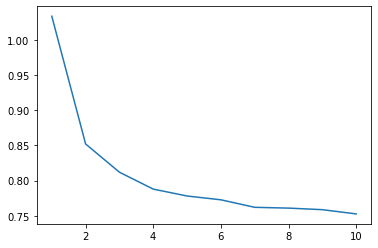

In [6]:
# plotting loss across the epochs
import numpy as np
my_plot(np.linspace(1, EPOCHS, EPOCHS).astype(int), loss_vals)

In [13]:
# predict stances for test set
model.eval()
predictions = []
for text, label, prev_text, prev_label in test_data_loader:
    with torch.no_grad():
        output = model(text)
        predict = output.max(dim=-1)[-1].item()
        predict = LABEL_MAP_REV[predict]
        predictions.append(predict)


In [8]:
from utils.dataset import DataSet
from utils.score import report_score, LABELS, score_submission
competition_dataset = DataSet("competition_test")
def generate_features(stances,dataset,name):
    h, b, y = [],[],[]

    for stance in stances:
        y.append(LABELS.index(stance['Stance']))
        h.append(stance['Headline'])
        b.append(dataset.articles[stance['Body ID']])
    return y
y_competition = generate_features(competition_dataset.stances, competition_dataset, "competition")
actual = [LABELS[int(a)] for a in y_competition]

Reading dataset
Total stances: 25413
Total bodies: 904


In [14]:
report_score(actual,predictions)

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    968    |    113    |    694    |    128    |
-------------------------------------------------------------
| disagree  |    204    |    149    |    224    |    120    |
-------------------------------------------------------------
|  discuss  |    678    |    230    |   3280    |    276    |
-------------------------------------------------------------
| unrelated |    46     |    11     |    249    |   18043   |
-------------------------------------------------------------
Score: 9443.5 out of 11651.25	(81.05138933590817%)


81.05138933590817

In [10]:
## visualize model
from torchviz import make_dot

batch = next(iter(DataLoader(dataset=train_all_dataset, batch_size=BATCH_SIZE, shuffle=False, sampler=sampler)))
yhat = model(batch[0])

make_dot(yhat, params=dict(list(model.named_parameters()))).render("fnc_torchviz", format="png")

'fnc_torchviz.png'

In [19]:
from sklearn.metrics import precision_score, recall_score
precision_score(actual,predictions, average='macro'), recall_score(actual,predictions, average='macro')

(0.6290312416448645, 0.6101335503490104)

In [20]:
with open("transformer_predictions.csv","w") as f:
    for prediction in predictions:
        f.write(prediction + "\n")